In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from sklearn.datasets import fetch_lfw_people
import matplotlib.cm as cm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

people.images.shape: (3023, 87, 65)
Number of classes: 62


Test set score of 1-nn: 0.23


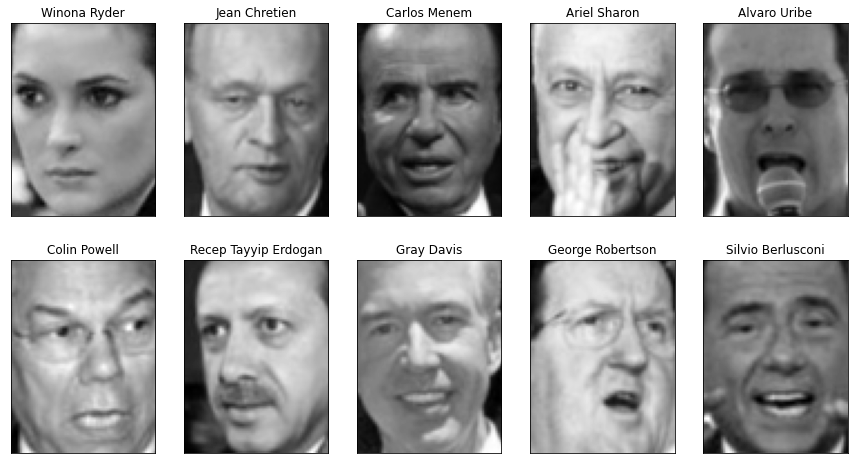

In [14]:
# Downloading all images needed

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fig, axes = plt.subplots(2,5,figsize=(15, 8), subplot_kw={'xticks':(), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap=cm.gray)
    ax.set_title(people.target_names[target])
    

    
#Verify the shape of the data    
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

#View skeweness of data
counts = np.bincount(people.target)
# for i, (count, name) in enumerate(zip(counts, people.target_names)):
#     print("{0:25} {1:3}".format(name, count), end="  ")
#     if (i+1)%3 == 0:
#         print()
        
#Make data less skewed
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
    
X_people = people.data[mask]
y_people = people.target[mask]

#Scale the grayscale to be between 0 and 1
X_people = X_people/255
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

#build a KNN using 1 neigbour
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("\n\nTest set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))




# **2**

My version of KNN using SSD accuracy: 0.23
My KNN accuracy using SSD with 100D data: 0.26
My KNN accuracy using SSD with 100D Whitened data: 0.35


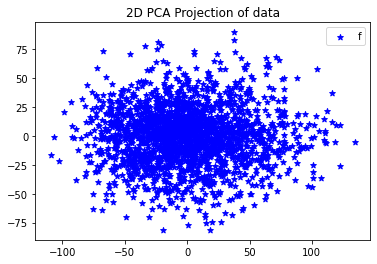

In [15]:
# #return accuracy everytime
# #Note this is a classifier for only one neighbour
def knnClassifier(X_train, X_test, y_train, y_test):
    #go through each x_test and calculate the difference between points with X_train

    yHat = []
    for i in range(len(X_test)):
        currentXTestVal = X_test[i]
        tempDist = []
        for k in range(len(X_train)):
            ssd = (X_train[k] - currentXTestVal) ** 2
            ssd_sum = np.sum(ssd,axis=0).tolist()
            tempDist.append(ssd_sum)
            
        # get index of minimum_dist and add
        indexMinTempDist = tempDist.index(np.min(tempDist))
        yHat.append(y_train[indexMinTempDist])
        
    #get the accuracy
    totalCorrect = 0
    for i in range(len(yHat)):
        if yHat[i] == y_test[i]:
            totalCorrect += 1
    
    accuracy = totalCorrect/len(yHat)
    return accuracy
            
    
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_people, y_people, stratify=y_people, random_state=0)
myImpl0 = knnClassifier(X_train_, X_test_, y_train_, y_test_)
print("My version of KNN using SSD accuracy: {:.2f}".format(myImpl0))

#Standardize the data
mean = X_people.mean(axis=0)
std = np.std(X_people, axis=0, ddof=1)

sX_people = (X_people - mean)/std    


# returns projected data of largest eigenvalues
# note that data must be standardadized
def PCA(whiten, numDim, data):
    #compute co-variance matrix
    cov_matrix = (data.T @ data)/(len(data)-1) 
    val, vec = np.linalg.eig(cov_matrix)
    
    idx = np.argsort(-1 * val)
    val = val[idx]
    vec = vec[:,idx]
    
    # top numDim eigenVectors in list
    topVectors = vec[:,:numDim]
    
    if whiten:
        topValues = val[:numDim]
        val = np.diag(1/np.sqrt(topValues))
        Z = data @ topVectors @ val
    else:
        Z = data @ topVectors
        
    return Z

pcaProjection = PCA(False, 100, sX_people)
pcaProjectionWhiten = PCA(True, 100, sX_people)


# # PCA projection with 100D 
X_train0, X_test0, y_train0, y_test0 = train_test_split(pcaProjection, y_people, stratify=y_people, random_state=0)
myImpl1 = knnClassifier(X_train0, X_test0, y_train0, y_test0)
print("My KNN accuracy using SSD with 100D data: {:.2f}".format(myImpl1))

# PCA projection with 100D whitened data
X_train1, X_test1, y_train1, y_test1 = train_test_split(pcaProjectionWhiten, y_people, stratify=y_people, random_state=0)
myImpl2 = knnClassifier(X_train1, X_test1, y_train1, y_test1)
print("My KNN accuracy using SSD with 100D Whitened data: {:.2f}".format(myImpl2))


#PCA projection with 2D data
pcaProjectionSmaller = PCA(False, 2, sX_people)
x = pcaProjectionSmaller[:,0]
y = pcaProjectionSmaller[:,1]

plt.scatter(x,-y,color='b', marker='*') 
plt.title("2D PCA Projection of data")
plt.legend("faces")
plt.show()



# **3**

In [16]:
# returns eigenvectors and eigenvalues
# note that data must be standardadized
def PCA_analysis(data):
    #compute co-variance matrix
    cov_matrix = (data.T @ data)/(len(data)-1)    
    val, vec = np.linalg.eig(cov_matrix)
    
    idx = np.argsort(-1 * val)
    val = val[idx]
    vec = vec[:,idx]

    return val, vec

#Standardize the data
eigen_values, eigen_vectors = PCA_analysis(sX_people)

Variation of PC1 captures: 0.27% of the data
Variation of PC2 captures: 0.11% of the data
We need only 197 PCs to encode 95% of the data


Text(0.5, 1.0, '95% Reconstruction of First person')

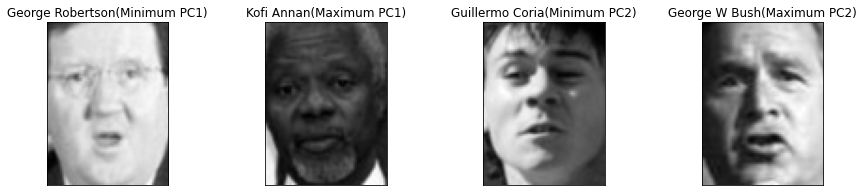

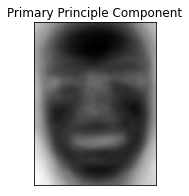

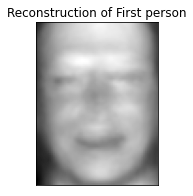

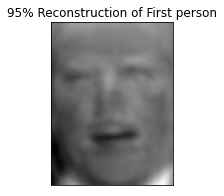

In [21]:
#don't forget to transpose the vector
#Get projection for PC1 and PC2

pc1_eigenVectors = eigen_vectors[:,0]
pc2_eigenVectors = eigen_vectors[:,1]

projection_PC1 = sX_people @ pc1_eigenVectors.T
projection_PC2 = sX_people @ pc2_eigenVectors.T

min_imagePC1_index = projection_PC1.argmin()
max_imagePC1_index = projection_PC1.argmax()
min_imagePC2_index = projection_PC2.argmin()
max_imagePC2_index = projection_PC2.argmax()

#Variations
pc1_eigenValue = eigen_values[0]
totalOfPCs = np.sum(eigen_values,axis=0).tolist()
print("Variation of PC1 captures: {:.2f}% of the data".format(pc1_eigenValue/totalOfPCs))

pc2_eigenValue = eigen_values[1]
print("Variation of PC2 captures: {:.2f}% of the data".format(pc2_eigenValue/totalOfPCs))

# plot of min/max of PC1 and PC2 respectively
minMaxIndex = [min_imagePC1_index, max_imagePC1_index, min_imagePC2_index, max_imagePC2_index]
minMaxTitle = ["Minimum PC1" ,"Maximum PC1", "Minimum PC2", "Maximum PC2"]
images_ = people.images[mask]
target_people = list(y_people[minMaxIndex]) #people.target
target_pictures = list(images_[minMaxIndex])

fig, axes = plt.subplots(1,4,figsize=(15, 3), subplot_kw={'xticks':(), 'yticks': ()})
cn = 0
for target, image, ax in zip(target_people, target_pictures, axes.ravel()):
    ax.imshow(image.real, cmap=cm.gray)
    ax.set_title(people.target_names[target]+"("+minMaxTitle[cn]+")")
    cn+=1

# Visualize PC1
fig, axes_ = plt.subplots(1,1,figsize=(15, 3), subplot_kw={'xticks':(), 'yticks': ()})
newShapePC1 = pc1_eigenVectors.reshape(87,65)
axes_.imshow(newShapePC1, cmap=cm.gray)
axes_.set_title("Primary Principle Component")


#Reconstruct Xtrain[0,:]
#Un-standardize first
row = X_train[0,:]
Zi = (row @ pc1_eigenVectors).reshape(1,1)
pc1_eigenVectors = pc1_eigenVectors.reshape(5655, 1)
recon = Zi @ pc1_eigenVectors.T
unData = (recon+mean)*std

fig, axes_ = plt.subplots(1,1,figsize=(15, 3), subplot_kw={'xticks':(), 'yticks': ()})
newShapeData = unData.reshape(87,65)
axes_.imshow(newShapeData.real, cmap=cm.gray)
axes_.set_title("Reconstruction of First person")


#count number of principal components needed for 95% encoding
total = np.sum(eigen_values,axis=0).tolist()
current = 0
count = 0
for i in range(len(eigen_values)):
    current += eigen_values[i]
    percent = (current/total) * 100
    count += 1
    if percent >= 95:
        print("We need only {:d} PCs to encode 95% of the data".format(count))
        break
    

# New reconstruction
pcs = eigen_vectors[:,0:count]
Zi = (row @ pcs).reshape(1,count)
recon = Zi @ pcs.T
un_Data = (recon+mean)*std

fig, axes_ = plt.subplots(1,1,figsize=(15, 3), subplot_kw={'xticks':(), 'yticks': ()})
newShapeData = un_Data.reshape(87,65)
axes_.imshow(newShapeData.real, cmap=cm.gray)
axes_.set_title("95% Reconstruction of First person")